# DIRAC Spatial Multi-Omics — Horizontal Integration
> Horizontal annotation with DIRAC. This Quickstart explains **how the demo runs** and what each step does, for both **single-modality** (RNA→RNA) and **dual-modality** (RNA+ATAC→RNA+ATAC) annotation using spatial graphs, plus an optional **novel cell type discovery** stage.

---

## Table of Contents

1. [Overview & Scope](#overview--scope)  
2. [Environment & Data](#environment--data)  
3. [Load Packages](#load-packages)  
4. [Single-Modality Annotation (RNA → RNA)](#single-omics-annotation)  
5. [Metrics & Visualization](#metrics--viz)  
6. [Dual-Modality Annotation (RNA+ATAC → RNA+ATAC)](#dual-omics-annotation)  
7. [Novel Cell Type Discovery (Confidence Filtering)](#novel-cell-types)  
8. [Tips & Troubleshooting](#tips--troubleshooting)

---

<a id="overview--scope"></a>
## 1) Overview & Scope

- **Goal:** Transfer cell type labels from a **source** dataset to a **target** dataset (horizontal integration) using DIRAC with spatial graphs.  
- **Included in this demo:**  
  1) **Single-modality annotation:** RNA → RNA  
  2) **Dual-modality annotation:** RNA+ATAC → RNA+ATAC (feature concatenation with explicit modality splits)  
  3) **Optional novel-cell discovery:** apply **confidence filtering** (e.g., threshold = 0.9) so low-confidence predictions are marked **"unassigned"**, revealing putative **missing/unknown** cell types when the reference is incomplete.

**High-level flow**  
1. Load AnnData for source and target.  
2. Preprocess each dataset (normalize → log1p → scale).  
3. Build spatial graphs: **multi-batch** (source) and **single-sample** (target).  
4. Initialize DIRAC’s **annotate_app**.  
5. Package data via `_get_data(...)` (optionally split into subgraphs with `num_parts_*`).  
6. Build a GNN via `_get_model(...)` (e.g., GraphSAGE or GAT).  
7. Train `_train_dirac_annotate(...)` to learn features & predict labels on the target.  
8. **(Optional)** Enable **confidence filtering** during training to tag low-confidence predictions as `"unassigned"`; tune `confidence_threshold` (e.g., 0.8–0.95) based on data quality and reference completeness.  
9. Write back embeddings/predictions; evaluate accuracy/precision/recall/F1 on **assigned** cells, report **Unassigned Rate**, and visualize spatial maps and confidence.

<a id="environment--data"></a>
## 2) Environment & Data

**Dependencies**
- Python ≥ 3.9  
- scanpy, anndata, numpy, matplotlib, scikit-learn, torch  
- DIRAC codebase available.  
  If not installed, follow: https://dirac-tutorial.readthedocs.io/en/latest/install.html

**Paths used in the demo**
- data_path: `../DIRAC-main/data/scMultiSim`  
- save_path: `./Results`  
- methods tag: `"DIRAC"`

**Expected input files**
- Single-modality: `source_RNA.h5ad`, `target_RNA.h5ad`  
- Dual-modality: additionally `source_ATAC.h5ad`, `target_ATAC.h5ad`

**Required fields in the AnnData**
- `obsm["spatial"]` for spatial coordinates (source & target)  
- `obs["batch"]` for source (used by multi-batch graph building)  
- `obs["cell.type"]` for source labels and target ground truth (for metrics)

**Download link:**  
We use **scMultiSim** benchmark data with **mask = 0.3**.
- https://drive.google.com/drive/folders/1GK_Ij0bVL9tRoHbBrYAjeywCB4ux5S-D?usp=drive_link

**What “mask = 0.3” means (important)** 
- A **dropout mask** is applied **independently** to both **RNA** and **ATAC** matrices.  
- Roughly **30% of entries are randomly set to zero** (element-wise), i.e., **random sparsification at rate 0.3** in **each** modality. 

---

<a id="load-packages"></a>
## 3) Load Packages

In [1]:
import os
import scanpy as sc
import numpy as np
import sys
import matplotlib.pyplot as plt
import anndata
import sklearn

sys.path.append("../DIRAC-main")
import sodirac_test as sd
sd.utils.seed_torch(seed=1)

data_path = "../DIRAC-main/data/scMultiSim"
save_path = './Results'
methods = "DIRAC"

---
<a id="single-omics-annotation"></a>
## 4) Single-Modality Annotation (RNA → RNA)

**What this part does**  
- Uses **RNA** only. Learns from `source_RNA.h5ad` (with cell types) and predicts labels for `target_RNA.h5ad`.  
- Builds a **multi-batch spatial graph** for source (accounts for `obs["batch"]`) and a **single-sample spatial graph** for target.

**Step-by-step (as in your script)**

In [2]:
# 1) Load source/target
source_RNA = anndata.read_h5ad(os.path.join(data_path, "source_RNA.h5ad"))
target_RNA = anndata.read_h5ad(os.path.join(data_path, "target_RNA.h5ad"))
print(source_RNA); print(target_RNA)

# 2) Preprocess (normalize → log1p → scale)
sc.pp.normalize_total(source_RNA)
sc.pp.log1p(source_RNA)
sc.pp.scale(source_RNA)

sc.pp.normalize_total(target_RNA)
sc.pp.log1p(target_RNA)
sc.pp.scale(target_RNA)

# 3) Spatial graphs
#  - Source: multi-batch kNN graph (uses spatial + batch)
source_edge_index = sd.utils.get_multi_edge_index(source_RNA.obsm["spatial"], source_RNA.obs["batch"], n_neighbors=10)
#  - Target: single-sample kNN graph
target_edge_index = sd.utils.get_single_edge_index(target_RNA.obsm["spatial"], n_neighbors=10)

# 4) Initialize DIRAC annotation app
annotate = sd.main.annotate_app(save_path=save_path, use_gpu=True)

# 5) Package data for training
samples = annotate._get_data(
        source_data=source_RNA.X,
        source_label=source_RNA.obs["cell.type"],
        source_edge_index=source_edge_index,
        target_data=target_RNA.X,
        target_edge_index=target_edge_index,
        num_parts_source=source_RNA.shape[0] // 200,
        num_parts_target=target_RNA.shape[0] // 200,
    )

# 6) Build model (GraphSAGE in this demo)
models = annotate._get_model(samples=samples)

# 7) Train
results = annotate._train_dirac_annotate(samples=samples, models=models, n_epochs=100)
# np.savez(os.path.join(save_path, "DIRAC_results.npz"), **results) 

# 8) Write back embeddings & predictions
source_RNA.obsm[f"{methods}_embed"] = results["source_feat"]
target_RNA.obsm[f"{methods}_embed"] = results["target_feat"]
target_RNA.obs[f"{methods}_pred"] = results["target_pred"]
target_RNA.obs[f"{methods}"] = target_RNA.obs[f"{methods}_pred"].map(results["pairs"])

AnnData object with n_obs × n_vars = 11971 × 200
    obs: 'pop', 'depth', 'cell.type', 'cell.type.idx', 'batch'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 3029 × 200
    obs: 'pop', 'depth', 'cell.type', 'cell.type.idx', 'batch'
    obsm: 'spatial'
Average neighbors per node (directed): 10.00 (edges=119710, nodes=11971)
Average neighbors per node (directed): 10.00 (edges=30290, nodes=3029)
Identified 2 unique domains.


Computing METIS partitioning...
Done!
Computing METIS partitioning...
Done!
DIRAC annotate training..: 100%|█| 10


---
<a id="metrics--viz"></a>
## 5) Metrics & Visualization

**Metrics (weighted, as in your script)**
- Accuracy, Precision (weighted), Recall (weighted), F1 (weighted) using sklearn.

**Spatial visualization**  
- Compare ground truth vs predicted labels on the target:

{'Accuracy Score': 0.880488610102344, 'Precision Score': 0.8821684104621875, 'Recall Score': 0.880488610102344, 'F1 Score': 0.8804397263487906}


[<Axes: title={'center': 'Ground truth'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'DIRAC ACC 0.880488610102344'}, xlabel='spatial1', ylabel='spatial2'>]

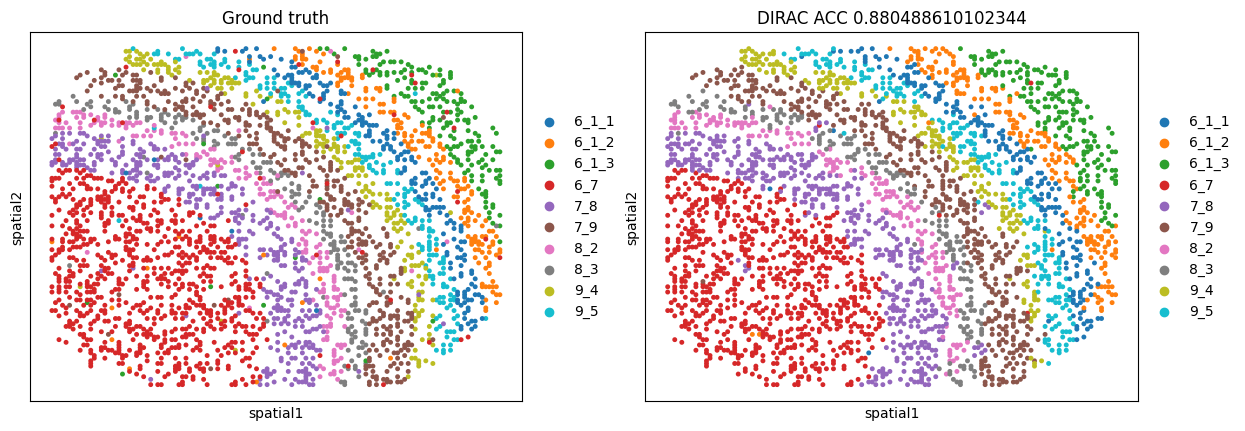

In [3]:
metrics_all = {
            "Accuracy Score":
                float(sklearn.metrics.accuracy_score(target_RNA.obs["cell.type"], target_RNA.obs[f"{methods}"])),
            "Precision Score":
                float(sklearn.metrics.precision_score(target_RNA.obs["cell.type"], target_RNA.obs[f"{methods}"], average='weighted')),
            "Recall Score":
                float(sklearn.metrics.recall_score(target_RNA.obs["cell.type"], target_RNA.obs[f"{methods}"], average='weighted')),
            "F1 Score":
                float(sklearn.metrics.f1_score(target_RNA.obs["cell.type"], target_RNA.obs[f"{methods}"], average='weighted'))}
print(metrics_all)

sc.pl.embedding(target_RNA, basis='spatial', color=['cell.type', f'{methods}'], title=['Ground truth',f"{methods} ACC {metrics_all['Accuracy Score']}"], s=50, show=False)

---

<a id="dual-omics-annotation"></a>
## 6) Dual-Modality Annotation (RNA+ATAC → RNA+ATAC)

**What this part does**  
- Concatenates **RNA** and **ATAC** features per cell and performs label transfer across modalities.  
- Uses `combine_multimodal_adatas(...)` to build a single AnnData with stacked features.  
- Provides a `split_list` to tell DIRAC where each modality lives in the concatenated matrix.

**Subgraph-settings(num_part)**
- The spatial graph is split into `num_parts_*` subgraphs. More parts → smaller subgraphs → lower peak memory but more overhead.
- Ensure at least 1 part: `max(1, n_cells // 200)`.
- When to increase: GPU OOM or very large tissues.

**Notes on `split_list`**  
- It must enumerate **non-overlapping half-open ranges** `(start, end)` that exactly cover the concatenated feature columns.  
- Make sure the ranges line up with the **same order** you used in `combine_multimodal_adatas({...})`.

**Step-by-step**

AnnData object with n_obs × n_vars = 11971 × 200
    obs: 'pop', 'depth', 'cell.type', 'cell.type.idx', 'batch'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 3029 × 200
    obs: 'pop', 'depth', 'cell.type', 'cell.type.idx', 'batch'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 11971 × 600
    obs: 'pop', 'depth', 'cell.type', 'cell.type.idx', 'batch'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 3029 × 600
    obs: 'pop', 'depth', 'cell.type', 'cell.type.idx', 'batch'
    obsm: 'spatial'
Average neighbors per node (directed): 10.00 (edges=119710, nodes=11971)
Average neighbors per node (directed): 10.00 (edges=30290, nodes=3029)
Identified 2 unique domains.


Computing METIS partitioning...
Done!
Computing METIS partitioning...
Done!
DIRAC annotate training..: 100%|█| 10


{'Accuracy Score': 0.9894354572466161, 'Precision Score': 0.9894781692014127, 'Recall Score': 0.9894354572466161, 'F1 Score': 0.9894421771682003}


[<Axes: title={'center': 'Ground truth'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'DIRAC ACC 0.9894354572466161'}, xlabel='spatial1', ylabel='spatial2'>]

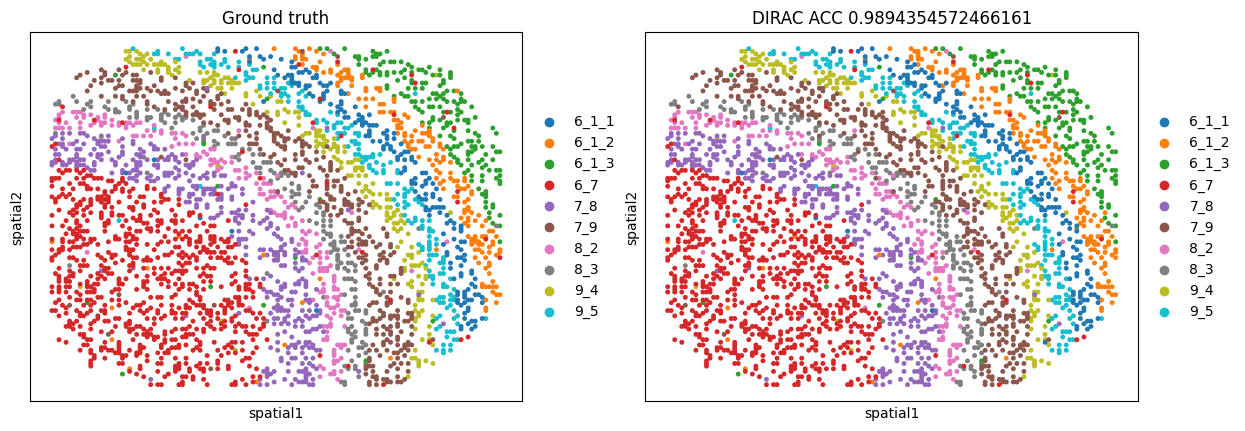

In [4]:
# 1) Load inputs
# RNA
source_adata_RNA = anndata.read_h5ad(os.path.join(data_path, "source_RNA.h5ad"))
target_adata_RNA = anndata.read_h5ad(os.path.join(data_path, "target_RNA.h5ad"))
print(source_adata_RNA); print(target_adata_RNA)

# ATAC
source_adata_ATAC = anndata.read_h5ad(os.path.join(data_path, "source_ATAC.h5ad"))
target_adata_ATAC = anndata.read_h5ad(os.path.join(data_path, "target_ATAC.h5ad"))
print(source_adata_ATAC); print(target_adata_ATAC)

# 2) Preprocess each modality
sc.pp.normalize_total(source_adata_RNA);  sc.pp.log1p(source_adata_RNA);  sc.pp.scale(source_adata_RNA)
sc.pp.normalize_total(target_adata_RNA);  sc.pp.log1p(target_adata_RNA);  sc.pp.scale(target_adata_RNA)

sc.pp.normalize_total(source_adata_ATAC); sc.pp.log1p(source_adata_ATAC); sc.pp.scale(source_adata_ATAC)
sc.pp.normalize_total(target_adata_ATAC); sc.pp.log1p(target_adata_ATAC); sc.pp.scale(target_adata_ATAC)

# 3) Concatenate modalities (feature-wise)
source_adata = sd.utils.combine_multimodal_adatas({"RNA": source_adata_RNA, "ATAC": source_adata_ATAC})
target_adata = sd.utils.combine_multimodal_adatas({"RNA": target_adata_RNA, "ATAC": target_adata_ATAC})

# 4) Spatial graphs
source_edge_index = sd.utils.get_multi_edge_index(source_adata.obsm["spatial"], source_adata.obs["batch"], n_neighbors=10)
target_edge_index = sd.utils.get_single_edge_index(target_adata.obsm["spatial"], n_neighbors=10)

# 5) Initialize DIRAC annotation app
annotate = sd.main.annotate_app(save_path=save_path, use_gpu=True)

# 6) Define modality splits in the concatenated matrix
#  RNA: [0, dim_RNA)
#  ATAC: [dim_RNA, dim_RNA + dim_ATAC)
split_list = [
        (0, source_adata_RNA.shape[1]),
        (source_adata_RNA.shape[1], source_adata_RNA.shape[1] + source_adata_ATAC.shape[1]),
    ]

# 7) Package data (note split_list)
samples = annotate._get_data(
        source_data=source_adata.X,
        source_label=source_adata.obs["cell.type"],
        source_edge_index=source_edge_index,
        target_data=target_adata.X,
        target_edge_index=target_edge_index,
        num_parts_source=source_adata.shape[0] // 200,
        num_parts_target=target_adata.shape[0] // 200,
        split_list=split_list,
    )

# 8) Build model and train
models = annotate._get_model(samples=samples, opt_GNN="SAGE")
results = annotate._train_dirac_annotate(samples=samples, models=models, n_epochs=100)

# 9) Write back outputs
source_adata.obsm[f"{methods}_embed"] = results["source_feat"]
target_adata.obsm[f"{methods}_embed"] = results["target_feat"]
target_adata.obs[f"{methods}_pred"] = results["target_pred"]
target_adata.obs[f"{methods}"] = target_adata.obs[f"{methods}_pred"].map(results["pairs"])

# 10) Metrics & Visualization
metrics_all = {
            "Accuracy Score":
                float(sklearn.metrics.accuracy_score(target_adata.obs["cell.type"], target_adata.obs[f"{methods}"])),
            "Precision Score":
                float(sklearn.metrics.precision_score(target_adata.obs["cell.type"], target_adata.obs[f"{methods}"], average='weighted')),
            "Recall Score":
                float(sklearn.metrics.recall_score(target_adata.obs["cell.type"], target_adata.obs[f"{methods}"], average='weighted')),
            "F1 Score":
                float(sklearn.metrics.f1_score(target_adata.obs["cell.type"], target_adata.obs[f"{methods}"], average='weighted'))}
print(metrics_all)

sc.pl.embedding(target_adata, basis='spatial', color=['cell.type', f'{methods}'], title=['Ground truth',f"{methods} ACC {metrics_all['Accuracy Score']}"], s=50, show=False)

---

<a id="novel-cell-types"></a>
## 7) Novel Cell Type Discovery (Confidence Filtering)

**Why this matters.** Real references are often **incomplete**: some cell types may be absent. Here we **intentionally drop two cell types from the reference**, train DIRAC, and then use a **confidence threshold** (default **0.9**, tunable) to mark **low-confidence predictions as `"unassigned"`**. This flags putative **novel/unknown** or **out-of-reference** cell types in the target.

**What happens.**
1) Randomly remove two reference cell types (`'7_9'`, `'6_1_2'` in this demo).  
2) Train DIRAC on the pruned reference and full target (RNA+ATAC).  
3) Use `filter_low_confidence=True` with `confidence_threshold=0.9`.  
4) Post-process: points below the threshold become `"unassigned"`.  
5) Report metrics on the **remaining assigned** cells and visualize confidence.

**Tip.** Increase the threshold (e.g., 0.95) for **stricter** assignment; relax it (e.g., 0.8) on **noisier** data.


AnnData object with n_obs × n_vars = 11971 × 200
    obs: 'pop', 'depth', 'cell.type', 'cell.type.idx', 'batch'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 3029 × 200
    obs: 'pop', 'depth', 'cell.type', 'cell.type.idx', 'batch'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 11971 × 600
    obs: 'pop', 'depth', 'cell.type', 'cell.type.idx', 'batch'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 3029 × 600
    obs: 'pop', 'depth', 'cell.type', 'cell.type.idx', 'batch'
    obsm: 'spatial'


Computing METIS partitioning...
Done!
Computing METIS partitioning...
Done!


Average neighbors per node (directed): 10.00 (edges=95610, nodes=9561)
Average neighbors per node (directed): 10.00 (edges=30290, nodes=3029)
Identified 2 unique domains.


DIRAC annotate training..: 100%|█| 10


[<Axes: title={'center': 'Ground truth'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'DIRAC ACC 0.9123914759273876'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'Confidence'}, xlabel='spatial1', ylabel='spatial2'>]

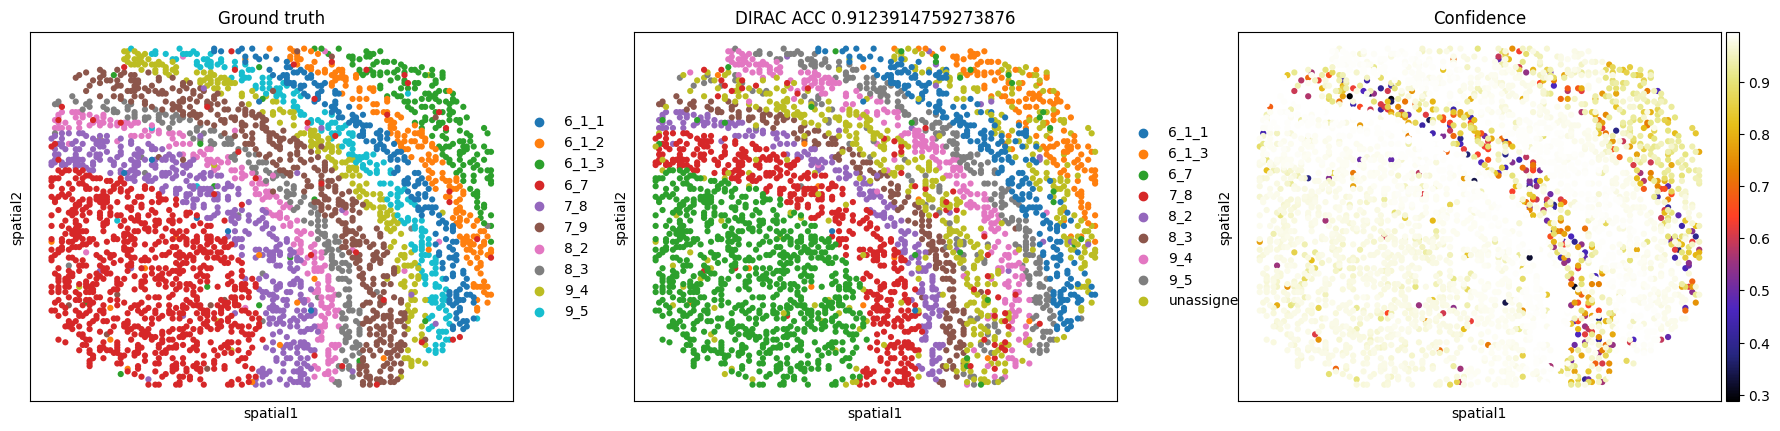

In [5]:
 # 1) Load inputs
# RNA
source_adata_RNA = anndata.read_h5ad(os.path.join(data_path, "source_RNA.h5ad"))
target_adata_RNA = anndata.read_h5ad(os.path.join(data_path, "target_RNA.h5ad"))
print(source_adata_RNA); print(target_adata_RNA)

# ATAC
source_adata_ATAC = anndata.read_h5ad(os.path.join(data_path, "source_ATAC.h5ad"))
target_adata_ATAC = anndata.read_h5ad(os.path.join(data_path, "target_ATAC.h5ad"))
print(source_adata_ATAC); print(target_adata_ATAC)

####### remove some cell types from reference data
drop_celltypes = ['7_9', '6_1_2']
source_adata_RNA = source_adata_RNA[~source_adata_RNA.obs['cell.type'].isin(drop_celltypes)].copy()
source_adata_ATAC = source_adata_ATAC[~source_adata_ATAC.obs['cell.type'].isin(drop_celltypes)].copy()

# 2) Preprocess each modality
sc.pp.normalize_total(source_adata_RNA);  sc.pp.log1p(source_adata_RNA);  sc.pp.scale(source_adata_RNA)
sc.pp.normalize_total(target_adata_RNA);  sc.pp.log1p(target_adata_RNA);  sc.pp.scale(target_adata_RNA)

sc.pp.normalize_total(source_adata_ATAC); sc.pp.log1p(source_adata_ATAC); sc.pp.scale(source_adata_ATAC)
sc.pp.normalize_total(target_adata_ATAC); sc.pp.log1p(target_adata_ATAC); sc.pp.scale(target_adata_ATAC)

# 3) Concatenate modalities (feature-wise)
source_adata = sd.utils.combine_multimodal_adatas({"RNA": source_adata_RNA, "ATAC": source_adata_ATAC})
target_adata = sd.utils.combine_multimodal_adatas({"RNA": target_adata_RNA, "ATAC": target_adata_ATAC})

# 4) Spatial graphs
source_edge_index = sd.utils.get_multi_edge_index(source_adata.obsm["spatial"], source_adata.obs["batch"], n_neighbors=10)
target_edge_index = sd.utils.get_single_edge_index(target_adata.obsm["spatial"], n_neighbors=10)

# 5) Initialize DIRAC annotation app
annotate = sd.main.annotate_app(save_path=save_path, use_gpu=True)

# 6) Define modality splits in the concatenated matrix
#  RNA: [0, dim_RNA)
#  ATAC: [dim_RNA, dim_RNA + dim_ATAC)
split_list = [
        (0, source_adata_RNA.shape[1]),
        (source_adata_RNA.shape[1], source_adata_RNA.shape[1] + source_adata_ATAC.shape[1]),
    ]

# 7) Package data (note split_list)
samples = annotate._get_data(
        source_data=source_adata.X,
        source_label=source_adata.obs["cell.type"],
        source_edge_index=source_edge_index,
        target_data=target_adata.X,
        target_edge_index=target_edge_index,
        num_parts_source=source_adata.shape[0] // 200,
        num_parts_target=target_adata.shape[0] // 200,
        split_list=split_list,
    )

# 8) Build model and train
models = annotate._get_model(samples=samples, opt_GNN="SAGE")
results = annotate._train_dirac_annotate(samples=samples, models=models, n_epochs=100,
                                         filter_low_confidence = True, # enable filtering
                                         confidence_threshold = 0.9) # tune this (e.g., 0.8–0.95)

# 9) Write back outputs
target_adata.obs[f"{methods}_pred"] = results["target_pred_filtered"]
target_adata.obs[f"{methods}"] = target_adata.obs[f"{methods}_pred"].map(results['pairs_filter'])
target_adata.obs["Confidence"] = results['target_confs']

# 10) Metrics (on assigned cells only) & Visualization
valid_mask = target_adata.obs[f"{methods}"] != "unassigned"
filtered_target = target_adata[valid_mask].copy()
metrics_all = {
                "Accuracy Score": float(sklearn.metrics.accuracy_score(
                    filtered_target.obs["cell.type"], 
                    filtered_target.obs[f"{methods}"])),
                "Precision Score": float(sklearn.metrics.precision_score(
                    filtered_target.obs["cell.type"], 
                    filtered_target.obs[f"{methods}"], 
                    average='weighted', zero_division=0)),
                "Recall Score": float(sklearn.metrics.recall_score(
                    filtered_target.obs["cell.type"], 
                    filtered_target.obs[f"{methods}"], 
                    average='weighted')),
                "F1 Score": float(sklearn.metrics.f1_score(
                    filtered_target.obs["cell.type"], 
                    filtered_target.obs[f"{methods}"], 
                    average='weighted')),
                "Unassigned Rate": float(1 - len(filtered_target)/len(target_adata))
                    }
sc.pl.embedding(target_adata, basis='spatial', color=['cell.type', f'{methods}', "Confidence"], 
                title=['Ground truth',f"DIRAC ACC {metrics_all['Accuracy Score']}", "Confidence"], 
                s=80, show=False, color_map="CMRmap")

---

<a id="tips--troubleshooting"></a>
## 8) Tips & Troubleshooting

- **Check required fields:** `obs["cell.type"]`, `obs["batch"]` (source), `obsm["spatial"]` (both).  
- **Class imbalance:** consider `weighted_classes=True`.  
- **Model choice:** `opt_GNN="SAGE"` is fast and strong; 
- **Epochs:** increase `n_epochs` if underfitting; decrease for faster prototyping.  
- **GPU memory:** raise `num_parts_*` or reduce batch sizes if exposed; ensure `use_gpu=True` only when CUDA is available.  
- **Modality splits:** verify `split_list` boundaries match feature concatenation order.  

---

**Summary**  
- **Single-modality (RNA→RNA)**: build source/target spatial graphs → train with GraphSAGE → predict → metrics → spatial maps.  
- **Dual-modality (RNA+ATAC)**: concatenate features and provide `split_list`; rest is identical.  
- **Novel cell type discovery**: train with **confidence filtering** to mark **"unassigned"** cells when the reference is incomplete; report **Unassigned Rate** alongside standard metrics.  
- Use `num_parts_*` to trade memory for speed, and tune neighbors/model/thresholds for stable, well-mixed embeddings and reliable annotations.